In [6]:
import os
import cv2
import dlib
import matplotlib.pyplot as plt
import numpy as np

#mkdir -p ~/aiffel/camera_sticker/models #디렉토리 생성
#mkdir -p ~/aiffel/camera_sticker/images #디렉토리 생성
#ln -s ~/data/* ~/aiffel/camera_sticker/images #이미지 연결

#wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 #weight file다운로드
#mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models #압출풀기
#cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

def make_sticker_img(img_path, sticker_path, img_w, img_h):
    #opencv로 이미지 읽어오기
    img_bgr = cv2.imread(img_path)
    img_bgr = cv2.resize(img_bgr, (img_w, img_h))
    
    #복사본
    img_show = img_bgr.copy()
    img_bgr2 = img_bgr.copy()
    img_addwei = img_bgr.copy()

    #opencv는 RGB대신에 BGR을 사용하기 때문에 RGB로 변경
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    #hog detector 선언
    detector_hog = dlib.get_frontal_face_detector() 
    dlib_rects = detector_hog(img_rgb, 1) 

    #얼굴부분
    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

    img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    
    model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)

    #landmark 찾기
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

    print(len(list_landmarks[0]))

    #landmark 출력
    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

    img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    
    #좌표
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):

        x1 = landmark[2][0]; y1 = landmark[2][1]
        x2 = landmark[30][0]; y2 = landmark[30][1]
        x3 = landmark[36][0]; y3 = landmark[36][1]
        x4 = landmark[48][0]; y4 = landmark[48][1]

        x5 = landmark[14][0]; y5 = landmark[2][1]
        x6 = landmark[30][0]; y6 = landmark[30][1]
        x7 = landmark[45][0]; y7 = landmark[36][1]
        x8 = landmark[54][0]; y8 = landmark[48][1]


        #4좌표가 주어질때 교점 구하기 : https://zetawiki.com/wiki/두_직선의_교차점

        Px = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4))//((x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4))
        Py = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4))//((x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4))
        cv2.circle(img_show, (Px,Py), 5, (0, 0, 255), -1)


        Px2 = ((x5*y6 - y5*x6)*(x7 - x8) - (x5 - x6)*(x7*y8 - y7*x8))//((x5 - x6)*(y7 - y8) - (y5 - y6)*(x7 - x8))
        Py2 = ((x5*y6 - y5*x6)*(y7 - y8) - (y5 - y6)*(x7*y8 - y7*x8))//((x5 - x6)*(y7 - y8) - (y5 - y6)*(x7 - x8))
        cv2.circle(img_show, (Px2,Py2), 5, (0, 0, 255), -1)


        w = Px2 - Px
        h = Px2 - Px


        #w = dlib_rect.width()
        #h = dlib_rect.width()
        print ('(x,y) : (%d,%d)'%(Px,Py))
        print ('(w,h) : (%d,%d)'%(w,h))

    #스티커이미지 불러오기
    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (w,h))

    #스티커이미지 좌표
    refined_x = Px # left
    refined_y = Py - img_sticker.shape[0]//2  # top

    print ('(x,y) : (%d,%d)'%(refined_x, refined_y))
    
    #y좌표가 음수일때 -y만큼 잘라주고 경계값 0으로 설정
    sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

    sticker_area2 = img_addwei[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

    img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
    
    #스티커적용
    sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

    img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
    
    fig = plt.figure()

    ax2 = fig.add_subplot(1,2,1)
    ax3 = fig.add_subplot(1,2,2)

    ax2.imshow(img_show_rgb)
    ax3.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))

    plt.show()


68
(x,y) : (249,271)
(w,h) : (121,121)
(x,y) : (249,211)


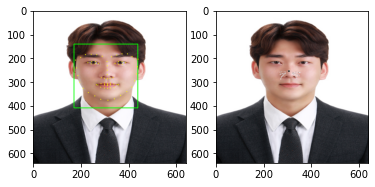

In [7]:
make_sticker_img(os.getenv('HOME')+'/aiffel/camera_sticker/images/img.png',\
                 os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_whiskers.png',640, 640)